# Hybrid phoneme recognizer

### Functions

In [1]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import torch
from scipy.fftpack import dct
#from IPython.display import display

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# pyspch
try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git@v0.6
except:
  IN_COLAB = False

# pyspch
import pyspch
import pyspch.nn
logging.basicConfig(level=logging.INFO)

D:\ProgramFiles\miniconda3\envs\pyspch_edit\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
#@title Auxiliary functions 

import requests
import importlib
import scipy.io as sio
import urllib.request
import pickle
import gzip

# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup

# loads all data in a matlab file at given url to the contents structure
# this is working for MATLAB 7.0 files and older ; not hdf5 MATLAB 7.3 or more recent
def load_matlab_from_url(url):
    url_response = urllib.request.urlopen(url)
    matio = io.BytesIO(url_response.read())
    contents = sio.loadmat(matio,squeeze_me=True)
    return(contents)

In [3]:
# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

In [17]:
# root url
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'

# paths
seg_url = root_url + 'segmentation/'

### Feed Forward DNN Model

In [6]:
# model
# = mfcc13, delta_delta2, meanvar, 11 frames, stride 2
model_path = 'models/default/mfcc13dd2mv/N5s2/' 

# read checkpoint 
model_fobj = pyspch.read_fobj(root_url + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)

# unpack checkpoint (model, etc)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
model.to(device)

FFDNN(
  (net): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=768, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=768, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=41, bias=True)
  )
)

### Evaluate posteriors on utterance

['0 56218 The reasons for this dive seemed foolish now.']


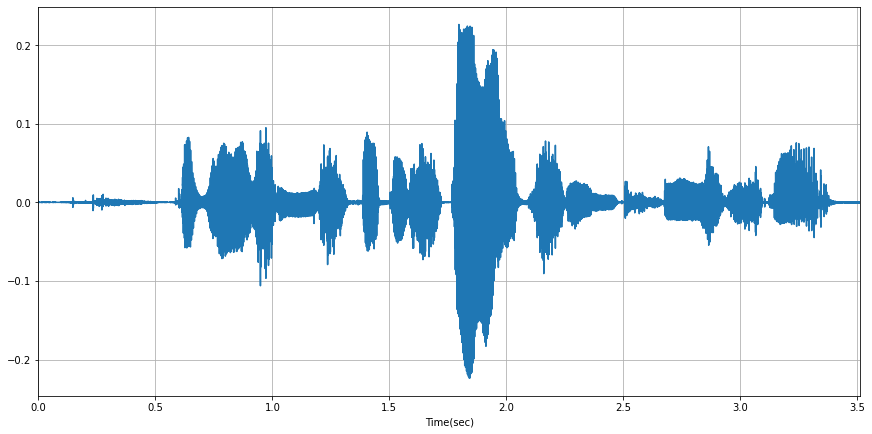

In [21]:
# select file to visualize
example = 'test/dr1/faks0/si2203'

# transcription + word segmentation 
example_txt = pyspch.read_txt(seg_url + example + ".txt")
example_wrd = pyspch.read_dataframe(seg_url + example + ".wrd", sep=" ", names=['t0','t1','wrd'])
print(example_txt)

# audio
example_audio, sample_rate = pyspch.audio.load(root_url + 'audio/' + example + ".wav")

# Visualization 
# - TODO: playable audio?
pyspch.display.PlotWaveform(waveform=example_audio,sample_rate=sample_rate)

In [ ]:
# labels (phone segmentation)
sample_rate = read_feature_args['sample_rate']
example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32", dt=1/sample_rate)
example_lab = pyspch.seg2lbls(example_phn) #length !!!
example_lab = [lab2lab[lbl] for lbl in example_lab]
example_idx = [lab2idx[lbl] for lbl in example_lab] # target


# feature + modification + splicing
example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

# tensor
example_X = torch.tensor(example_spliced).T.float().to(device)
example_y = torch.tensor(example_idx).long().to(device)

# prediction 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs